In [1]:
import numpy as np
from clust import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)

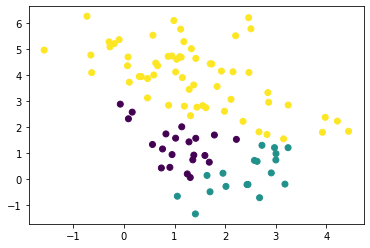

In [13]:
m = KMeans(3).fit(X)
x, y = np.hsplit(X, 2)
c1, c2 = np.hsplit(m.centroids, 2)
plt.scatter(x, y, c=m.labels)


In [11]:
m.near(7)

array([6, 4])